## Практикум 1. Задание.

Используя библиотеки, pandas, requests, pyod:
1. Скачать json с 2000 вакансий по специальности Разработчик применяя api.hh.ru, без ограничения региона, с указанием зп
(параметр запроса only_with_salary=True)
2. На основе полученного json создать таблицу Pandas DataFrame df из полей - id, name, area.name, salary.from, salary.to, salary.gross, salary.currency, snippet.requirements, experience.name
3. Создать новое поле clean_sal, усредняющее предлагаемую в вакансии зп, на основе известных сумм "от" и "до".
4. С использованием boxplot определить наличие аномальных значений в полученном столбце
5. С использованием библиотеки pyod, выбрать 3 метода без учителя, определения аномалий, и на основе их результатов, добавить в датафрейм df поля - anomaly1, anomaly2, anomaly3.
6. С использованием голосования большинством получить столбец anomaly, по 3-м полям выше
7. Для каждой из аномалий, ориентируясь на название вакансии, требуемый опыт, регион, требования к вакансии, получить объяснение и в виде категории с кратким текстом, описывающим ее суть, добавить эти объяснения отдельным столбцом в датафрейм
8. Результирующий датафрейм в виде xls файла, текстовый файл со ссылкой на колаб с результатами добавить в архив со своими фио и загрузить в результаты ПР1. Результаты

In [1]:
import pandas as pd
import requests
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.auto_encoder_torch import AutoEncoder
import matplotlib.pyplot as plt

####  1. Скачиваем данные

In [2]:
url = "https://api.hh.ru/vacancies"

data = []
for i in range(20):
    params = {
        "text": "Разработчик",
        "area": 1,
        "per_page": 100,
        "page": i,
        "only_with_salary": True
    }
    response = requests.get(url, params=params)
    data += response.json()["items"]

In [3]:
len(data)

2000

In [4]:
data

[{'id': '107774180',
  'premium': False,
  'name': 'Junior Frontend-разработчик',
  'department': None,
  'has_test': False,
  'response_letter_required': False,
  'area': {'id': '1', 'name': 'Москва', 'url': 'https://api.hh.ru/areas/1'},
  'salary': {'from': 60000, 'to': None, 'currency': 'RUR', 'gross': False},
  'type': {'id': 'open', 'name': 'Открытая'},
  'address': {'city': 'Москва',
   'street': 'Пресненская набережная',
   'building': '12',
   'lat': 55.749633,
   'lng': 37.537434,
   'description': None,
   'raw': 'Москва, Пресненская набережная, 12',
   'metro': None,
   'metro_stations': [],
   'id': '13626960'},
  'response_url': None,
  'sort_point_distance': None,
  'published_at': '2024-09-25T17:07:29+0300',
  'created_at': '2024-09-25T17:07:29+0300',
  'archived': False,
  'apply_alternate_url': 'https://hh.ru/applicant/vacancy_response?vacancyId=107774180',
  'show_logo_in_search': None,
  'insider_interview': None,
  'url': 'https://api.hh.ru/vacancies/107774180?host=

#### 2. Создаем DataFrame

In [5]:
df = pd.DataFrame(data)
df = df[["id", "name", "area", "salary", "snippet", "experience"]]
df["area.name"] = df["area"].apply(lambda x: x["name"])
df["salary.from"] = df["salary"].apply(lambda x: x["from"])
df["salary.to"] = df["salary"].apply(lambda x: x["to"])
df["salary.gross"] = df["salary"].apply(lambda x: x["gross"])
df["salary.currency"] = df["salary"].apply(lambda x: x["currency"])
df["snippet.requirements"] = df["snippet"].apply(lambda x: x.get("requirement", ""))
df["experience.name"] = df["experience"].apply(lambda x: x["name"])

In [6]:
df["salary.to"].count()

1243

In [7]:
df["salary.from"].count()

1658

#### 3. Создаем поле с чистой зарплатой

In [8]:
def convert_salary(row):
    salary_from = row["salary.from"] if row["salary.from"] > 0 else 0
    salary_to = row["salary.to"] if row["salary.to"] > 0 else 0
    currency = row["salary.currency"]
    gross = row["salary.gross"]

    if currency == "USD":
        salary_from *= 90
        salary_to *= 90
    elif currency == "EUR":
        salary_from *= 100
        salary_to *= 100
    if gross:
        salary_from *= 0.87
        salary_to *= 0.87

    if salary_from == 0 and salary_to == 0:
        return 0
    elif salary_from == 0:
        return salary_to
    elif salary_to == 0:
        return salary_from
    else:
        return (salary_from + salary_to) / 2


df["clean_sal"] = df.apply(convert_salary, axis=1)

#### 4. Определяем аномалии визуально

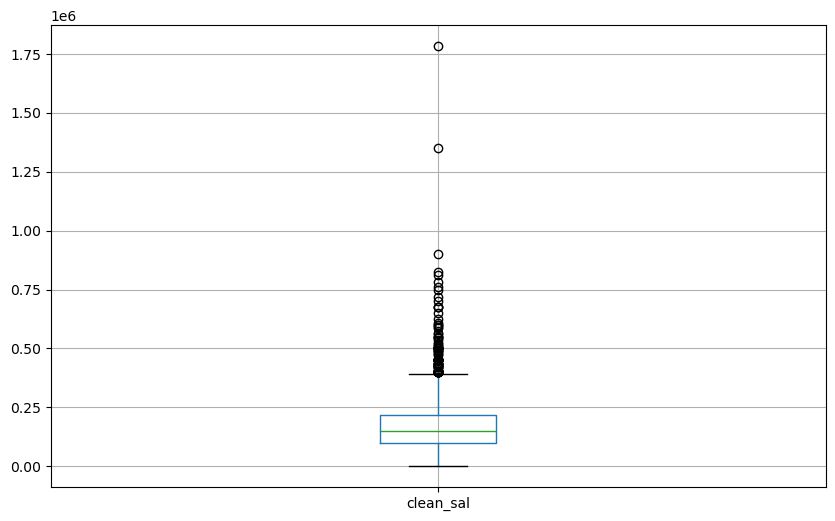

In [9]:
plt.figure(figsize=(10, 6))
df.boxplot(column=["clean_sal"])
plt.show()

#### 5. Используем `pyod` для определения аномалий

In [11]:
X = df[["clean_sal"]].values

models = {
    "KNN": KNN(),
    "IForest": IForest(),
    "AutoEncoder": AutoEncoder()
}

for name, model in models.items():
    model.fit(X)
    df[f"anomaly_{name}"] = model.labels_

InnerAutoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=1, out_features=64, bias=True)
    (batch_norm0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (batch_norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (batch_norm0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=1, bias=True)
    (relu1): ReLU()
  )
)
epoch 0: training loss 0.5307888140281042 
epoch 1: training loss 0.4303875548972024 
epoch 2: training loss 0.43486764317

#### 6. Голосование большинством

In [16]:
df["anomaly"] = df[[f"anomaly_{name}" for name in models]].mode(axis=1)[0]

df["anomaly_explanation"] = df.apply(
    lambda row: f"Anomaly in {row['name']} with experience {row['experience.name']} in {row['area.name']}" if row['anomaly'] else "", axis=1)

#### 7. Сохраняем результат в XLS файл

In [17]:
df

,id,name,area,salary,snippet,experience,area.name,salary.from,salary.to,salary.gross,salary.currency,snippet.requirements,experience.name,clean_sal,anomaly_KNN,anomaly_IForest,anomaly_AutoEncoder,anomaly,anomaly_explanation
0,107774180,Junior Frontend-разработчик,"{'id': '1', 'name': 'Москва', 'url': 'https://api.hh.ru/areas/1'}","{'from': 60000, 'to': None, 'currency': 'RUR', 'gross': False}","{'requirement': 'Знание React. Знание любого UI-Kit (Ant Design, MUI, и т.д.). Опыт работы с любым из менеджеров состояний(Redux...', 'responsibility': 'Разработка клиентской части проектов компании.'}","{'id': 'noExperience', 'name': 'Нет опыта'}",Москва,60000.0,NaN,False,RUR,"Знание React. Знание любого UI-Kit (Ant Design, MUI, и т.д.). Опыт работы с любым из менеджеров состояний(Redux...",Нет опыта,60000.0,0,0,0,0,
1,106912067,Начинающий специалист СРОЧНО! ОБУЧИМ,"{'id': '1', 'name': 'Москва', 'url': 'https://api.hh.ru/areas/1'}","{'from': 90000, 'to': None, 'currency': 'RUR', 'gross': False}","{'requirement': 'От Вас: Желание развиваться и зарабатывать выше рынка. Клиентоориентированность. Опыт работы в клиентском сервисе, продажах или в недвижимости будет Вашим...', 'responsibility': 'Изучать рынок недвижимости совместно с наставником. Подбирать варианты по запросу клиента. Помощь юристов , ипотечных брокеров, маркетологов и других смежных отделов. '}","{'id': 'noExperience', 'name': 'Нет опыта'}",Москва,90000.0,NaN,False,RUR,"От Вас: Желание развиваться и зарабатывать выше рынка. Клиентоориентированность. Опыт работы в клиентском сервисе, продажах или в недвижимости будет Вашим...",Нет опыта,90000.0,0,0,0,0,
2,107877997,Руководитель проектов,"{'id': '1', 'name': 'Москва', 'url': 'https://api.hh.ru/areas/1'}","{'from': 450000, 'to': None, 'currency': 'RUR', 'gross': False}","{'requirement': 'опыт постановки задач аналитикам и <highlighttext>разработчикам</highlighttext>. -практический опыт написания и проверки отчетной документации. -знание нотаций моделирования бизнес-процессов (UML, BPMN...', 'responsibility': 'по управлению проектами (PMBOK, PRINCE2, Agile, Scrum и т.д.), По планированию работ (Project, Jira и т.д.). -'}","{'id': 'moreThan6', 'name': 'Более 6 лет'}",Москва,450000.0,NaN,False,RUR,"опыт постановки задач аналитикам и <highlighttext>разработчикам</highlighttext>. -практический опыт написания и проверки отчетной документации. -знание нотаций моделирования бизнес-процессов (UML, BPMN...",Более 6 лет,450000.0,0,1,0,0,
3,107654802,Инженер по техническому обслуживанию,"{'id': '1', 'name': 'Москва', 'url': 'https://api.hh.ru/areas/1'}","{'from': 200000, 'to': 300000, 'currency': 'RUR', 'gross': True}","{'requirement': '2. Have deep experience in mainstream brand of Medium-Voltage AC drive,engineering AC drive,Low-Voltage AC drive,etc...', 'responsibility': '5. Participate in training materials/documents <highlighttext>development</highlighttext> and translation. 6. Identify and connect with potential service partners,organize training and...'}","{'id': 'moreThan6', 'name': 'Более 6 лет'}",Москва,200000.0,300000.0,True,RUR,"2. Have deep experience in mainstream brand of Medium-Voltage AC drive,engineering AC drive,Low-Voltage AC drive,etc...",Более 6 лет,217500.0,0,0,0,0,
4,107886528,Руководитель департамента стратегического анализа и маркетинга (Девелопмент),"{'id': '1', 'name': 'Москва', 'url': 'https://api.hh.ru/areas/1'}","{'from': 500000, 'to': None, 'currency': 'RUR', 'gross': False}","{'requirement': 'Высшее образование в области маркетинга, экономики или финансов. Опыт работы на аналогичной позиции не менее 3 лет. Опыт анализа и...', 'responsibility': 'Анализ текущих рыночных тенденций и конкурентной среды, включая анализ международного рынка. Анализ перспективных участков для реализации девелоперских проектов на целевых...'}","{'id': 'between3And6', 'name': 'От 3 до 6 лет'}",Москва,500000.0,NaN,False,RUR,"Высшее образование в области маркетинга, экономики или финансов. Опыт работы на аналогичной позиции не менее 3

In [20]:
df.to_excel("data/result.xlsx", index=False)